## Data Preparation
Once the dataset has been profiled to gain a better understanding of its dimensionality, its quality, and the content and distribution of values in its features (columns), the next activity is to address any defects that were identified to prepare the data for exploratory data analysis (EDA) and for training and evaluating machine learning models. Depending on which defects were identified, activities may involve removing duplicate observations and deciding whether to exclude observations (rows) or features (columns) that contain missing or corrupt data, or to impute new values into those tuples.

#### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

#### Import the Data

In [2]:
data_dir = os.path.join(os.getcwd(), 'Data')
source_data_file = 'titanic.csv';

data_file = os.path.join(data_dir, source_data_file)
df = pd.read_csv(data_file, header=0, index_col=0)

# Ensure the index values are: seed=1, increment=1
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape[0]} Observations x {df.shape[1]} Features")

Shape: 1309 Observations x 13 Features


### 1.0. Removing Duplicate Observations
While performing the initial profile it was determined that there were 2 more observations (rows) then there were unique values in the **name** feature. We then identified two passengers (Kate Connolly and James Kelly) with duplicate records. In each case, the first observation contained fewer missing values (NaN) so they should be kept with the second instances being excluded. For the sake of training a model this really shouldn't have any appreciable impact, but it is useful to know how to de-duplicate a dataset in situations where there could possibly be a negative impact. Also, since each passenger's *name* is certain to have no logical correlation to whether or not they survived, once the data has been de-duplicated it will be safe to exclude the **name** feature.

In [3]:
df.drop_duplicates(subset='name', keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(['name'], axis=1, inplace=True)

print(f"Shape: {df.shape[0]} Observations x {df.shape[1]} Features")

Shape: 1307 Observations x 12 Features


### 2.0. Modifying the Data Type of Categorical Features Having Numerical Values

While performing the initial profile, some features having numerical data types were detected that contain values which may also be considered categorical (e.g., survived, sibsp, parch). While **sibsp** and **parch** are, in fact, summable numerical values their discrete nature and limited range indicates that they may influence the *Target* more if treated as categorical values. Here those features will be converted from their present numerical types to the *Object* type to indicate their categorical nature. What's more, a new feature (survived_desc) will be created wherein descriptive labels will be mapped to the Target variable's (survived) existing numerical values. This new column will be used to enhance some visualizations that will be created while conducting exploratory data analysis (EDA).

In [4]:
df['survived_desc'] = df.survived.map({0 : 'perished', 1 : 'survived'})

In [5]:
df[['survived','sibsp','parch']] = df[['survived','sibsp','parch']].astype('object')
df.dtypes

survived          object
sex               object
age              float64
sibsp             object
parch             object
ticket            object
fare             float64
cabin             object
embarked          object
boat              object
body             float64
home.dest         object
survived_desc     object
dtype: object

### 3.0. Complete-Case Analysis *(Removing Missing Values)*
Complete Case Analysis (CCA), also called "list-wise deletion" of cases, involves analyzing only those observations where all of the variables in the data set contain useful data. Subsequently, complete-case analysis consists of discarding observations where values in any of the variables are missing. Implementing CCA is prudent for the sake of avoiding any future doubt with regards to either the validity of any correlations that might be observed among the features, or the efficacy of any models that might be trained using the sample. However, in situations where the remaining sample would be too small to effectively train and test machine learning models there may be no other choice, besides sourcing additional data, than to impute missing values.

#### 3.1. Quantify Missing Values

In [6]:
df.isnull().sum().sort_values(ascending=True)

survived            0
sex                 0
sibsp               0
parch               0
ticket              0
survived_desc       0
fare                1
embarked            2
age               263
home.dest         563
boat              821
cabin            1012
body             1186
dtype: int64

#### 3.2. Experiment with Dropping All Observations Containing Missing Values (CCA)

In [7]:
df_cca = df.dropna()
print(f"Shape: {df_cca.shape[0]} Observations x {df_cca.shape[1]} Features")

Shape: 0 Observations x 13 Features


#### 3.3. Experiment with Dropping Observations by Subsetting Features

In [8]:
df_cca = df.dropna(subset=['survived','sex','sibsp','parch','ticket'
                           ,'fare','embarked','age','home.dest'
                           #,'home.dest','boat','cabin','body'
    ])
print(f"Shape: {df_cca.shape[0]} Observations x {df_cca.shape[1]} Features")

Shape: 683 Observations x 13 Features


Our experimentation has revealed that there are so many missing values that removing them all would either leave too few observations, or exclude potentially influential features. In this situation it may be necessary to experiment with various methods for imputing missing values.


### 4.0. Imputing Missing Values
The following sections demonstrate how to impute missing values (e.g., NaN or NULL) using two different approaches: using Pandas, and using Scikit-Learn's SimpleImputer.  The advantage of using the SimpleImputer is that is can be used to build Scikit-Learn Pipelines which both streamline and formalize the process into reusable processes called *pipelines*.

The approach implemented to impute missing values is driven by the nature of the data the feature contains. The first thing to consider is whether the feature contains numerical or categorical data. If the feature is numerical then the following techniques may be most appropriate:
- Imputing with the Mean or Median
- Imputing with the Mode
- Imputing with an Arbitrary Number
- Imputing with a Value at the End of the Distribution
- Imputing with a Random Sample
- Imputing with MICE (Multivariate Imputation by Chained Equations)

If the feature is categorical then the following techniques may be more appropriate:
- Imputing with a Custom Category
- Imputing with the Most Frequent Category
- Imputing with MICE (Multivariate Imputation by Chained Equations)
- Imputing with a Missing-Value Indicator

#### Separate Numerical and Categorical Features

In [9]:
numerical_cols = [col for col in df.columns if df.dtypes[col] != 'O']
categorical_cols = [col for col in df.columns if col not in numerical_cols]

print(numerical_cols)
print(categorical_cols)

['age', 'fare', 'body']
['survived', 'sex', 'sibsp', 'parch', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest', 'survived_desc']


### 4.1. Imputing Numerical Values
#### 4.1.1. Impute Missing Values with the Median or the Mean
When imputing numerical variables a reasonable first approach would be to estimate missing values using either the **mean** of the remaining non-null observations, if the variable is reasonable parametric, or with the **median** of those remaining values if the variable contains outliers that would apply too much leverage against its appropriate mean.

##### Using Pandas

In [10]:
df_pd = df.copy() # Make a copy of the dataframe.

for col in numerical_cols:
    median = df_pd[col].median()
    df_pd[col] = df_pd[col].fillna(median)
    
df_pd[numerical_cols].isnull().sum()

age     0
fare    0
body    0
dtype: int64

##### Using Scikit-Learn

In [11]:
df_sk = df.copy() # Make a copy of the dataframe

imputer = SimpleImputer(strategy='median')
imputer.fit(df_sk[numerical_cols])
imputer.statistics_

array([ 28.    ,  14.4542, 155.    ])

#### 4.1.2. Impute Missing Values with the Mode
Mode imputation consists of replacing all occurrences of missing values (NA) within a variable by the mode; i.e., the most frequently occuring value.
##### Using Pandas

In [12]:
df_pd = df.copy() # Make a copy of the dataframe.

for col in numerical_cols:
    mode = df_pd[col].mode()[0]
    df_pd[col] = df_pd[col].fillna(mode)
    
df_pd[numerical_cols].isnull().sum()

age     0
fare    0
body    0
dtype: int64

##### Using Scikit-Learn

In [13]:
df_sk = df.copy() # Make a copy of the dataframe

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df_sk[numerical_cols])
imputer.statistics_

array([24.  ,  8.05,  1.  ])

#### 4.1.3. Impute Missing Values with an Arbitrary Number
##### First, inspect the maximum value per feature to ensure the arbitrary number doesn't overlap existing values

In [14]:
df[numerical_cols].max()

age      80.0000
fare    512.3292
body    328.0000
dtype: float64

In [15]:
df_pd = df.copy() # Make a copy of the dataframe.

for col in numerical_cols:
    df_pd[col].fillna(999, inplace=True)
    
df_pd[numerical_cols].isnull().sum()

age     0
fare    0
body    0
dtype: int64

##### Using Scikit-Learn

In [16]:
df_sk = df.copy() # Make a copy of the dataframe

imputer = SimpleImputer(strategy='constant', fill_value=999)
imputer.fit(df_sk[numerical_cols])
imputer.statistics_

array([999., 999., 999.])

#### 4.1.4. Imputing with a Value at the End of the Distribution
Here we will replace missing values by a value at the end of the distribution, estimated with the Gaussian approximation or the inter-quantal range proximity rule, using Pandas.

In [17]:
df_pd = df.copy() # Make a copy of the dataframe.

for col in numerical_cols:
    IQR = df_pd[col].quantile(0.75) - df_pd[col].quantile(0.25)
    value = df_pd[col].quantile(0.75) + 1.25 * IQR
    df_pd[col] = df_pd[col].fillna(value)
    
df_pd[numerical_cols].isnull().sum()

age     0
fare    0
body    0
dtype: int64

#### 4.1.5. Impute Missing Values with a Random Sample

In [18]:
df_pd = df.copy() # Make a copy of the dataframe.

for col in numerical_cols:
    number_missing_values = df_pd[col].isnull().sum()
    random_sample = df_pd[col].dropna().sample(number_missing_values, replace=True, random_state=0)
    random_sample.index = df_pd[df_pd[col].isnull()].index
    df_pd.loc[df_pd[col].isnull(), col] = random_sample
    
df_pd[numerical_cols].isnull().sum()

age     0
fare    0
body    0
dtype: int64

#### 4.1.6. Impute Missing Values with MICE (Multivariate Imputation by Chained Equations) Using Scikit-Learn
The imputation techniques implemented so far have been **univariate** imputations; i.e., the values are either statitically assigned, or are estimated (calculated) using the non-null values present in the specified variable. Conversely, **multivariate** imputation techniques estimate new values taking into account the values present in all the variables (features) in the dataset. Multivariate Imputation by Chained Equations (MICE) is an imputation technique that models each variable with missing values as a function of the remaining variables and uses that estimate for imputation. Each variable with missing data can be modeled based on the remaining variable using any one of many estimators (e.g., Bayes, k-nearest neighbors, decision trees, random forests, linear regression).
##### Using a Bayesian Ridge estimator

In [19]:
df_sk = df.copy() # Make a copy of the dataframe.

bayes = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0)
bayes.fit(df_sk[numerical_cols])

df_bayes = bayes.transform(df_sk[numerical_cols])

##### Use a K-Nearest Neighbors (KNN) estimator

In [20]:
knn = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5), max_iter=10, random_state=0)
knn.fit(df_sk[numerical_cols])

df_knn = knn.transform(df_sk[numerical_cols])

##### Use a Decision Tree Regressor estimator

In [21]:
dtr = IterativeImputer(estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0)
dtr.fit(df_sk[numerical_cols])

df_dtr = dtr.transform(df_sk[numerical_cols])

##### Use an Extra Trees Regressor estimator

In [22]:
etr = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=10, random_state=0)
etr.fit(df_sk[numerical_cols])

df_etr = etr.transform(df_sk[numerical_cols])

##### Plot to Compare the Performance of Each estimator

In [23]:
df_bayes = pd.DataFrame(df_bayes, columns=numerical_cols)
df_knn = pd.DataFrame(df_knn, columns=numerical_cols)
df_dtr = pd.DataFrame(df_dtr, columns=numerical_cols)
df_etr = pd.DataFrame(df_etr, columns=numerical_cols)

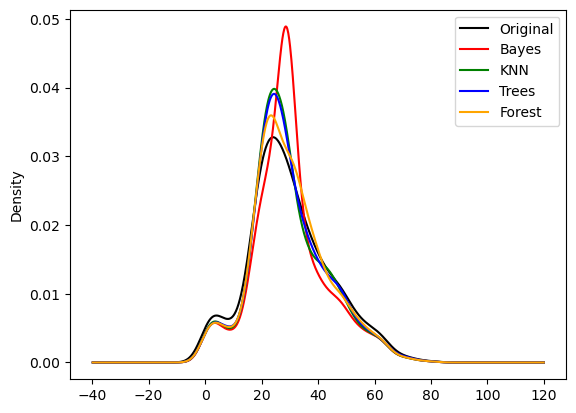

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

df.age.plot(kind='kde', ax=ax, color='black')
df_bayes.age.plot(kind='kde', ax=ax, color='red')
df_knn.age.plot(kind='kde', ax=ax, color='green')
df_dtr.age.plot(kind='kde', ax=ax, color='blue')
df_etr.age.plot(kind='kde', ax=ax, color='orange')

lines, labels = ax.get_legend_handles_labels()
labels = ['Original','Bayes','KNN','Trees','Forest']
ax.legend(lines, labels, loc='best')

plt.show()

This comparison clearly illustrates that the Bayes algorithm outperforms the others; therefore, it should be used for any MICE imputations against this dataset.

### 4.2. Imputing Categorical Values

##### Inspect the percentage of missing values in each categorical variable

In [25]:
df[categorical_cols].isnull().mean()

survived         0.000000
sex              0.000000
sibsp            0.000000
parch            0.000000
ticket           0.000000
cabin            0.774292
embarked         0.001530
boat             0.628156
home.dest        0.430757
survived_desc    0.000000
dtype: float64

##### Exclude categorical variables having no missing values

In [26]:
del categorical_cols[0:5]  # survived, sex, sibsp, parch, ticket
del categorical_cols[-1]   # survived_desc

categorical_cols

['cabin', 'embarked', 'boat', 'home.dest']

#### 4.2.1. Impute Missing Values with a Custom Category
When handling missing values in Categorical features, it is customary to create an additional category by imputing the value 'Unknown', or 'Missing' into those tuples where NULL or NaN values occur.

##### Using Pandas

In [27]:
df_pd = df.copy()

for col in categorical_cols:
    df_pd[col].fillna('Unknown', inplace=True)
    
df_pd[categorical_cols].isnull().sum()

cabin        0
embarked     0
boat         0
home.dest    0
dtype: int64

##### Using Scikit-Learn

In [28]:
df_sk = df.copy()

imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
imputer.fit(df_sk[categorical_cols])

imputer.statistics_

array(['Unknown', 'Unknown', 'Unknown', 'Unknown'], dtype=object)

#### 4.2.2. Impute Missing Values with the Most Frequently Category
Most frequent category imputation consists of replacing all occurrences of missing values within a variable with the most frequently occuring value (mode).
##### Using Pandas

In [29]:
df_pd = df.copy()

for col in categorical_cols:
    mode = df_pd[col].mode()[0]
    df_pd[col] = df_pd[col].fillna(mode)
    
df_pd[categorical_cols].isnull().sum()

cabin        0
embarked     0
boat         0
home.dest    0
dtype: int64

##### Using Scikit-Learn

In [30]:
df_sk = df.copy()

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df_sk[numerical_cols])
imputer.statistics_

array([24.  ,  8.05,  1.  ])

#### 4.2.3. Impute Missing Values with a Missing-Value Indicator

##### Using Pandas

In [31]:
df_pd = df.copy()

for col in categorical_cols:
    df_pd[col+'_NA'] = np.where(df_pd[col].isnull(), 1, 0)
    
df_pd.head(2)

,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived_desc,cabin_NA,embarked_NA,boat_NA,home.dest_NA
0,1,female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",survived,0,0,0,0
1,1,male,0.9167,1,2,113781,151.5500,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON",survived,0,0,0,0


##### Using Scikit-Learn

In [32]:
df_sk = df.copy()

indicator = MissingIndicator(error_on_new=True, features='missing-only')
indicator.fit(df_sk)
indicator.features_

array([ 2,  6,  7,  8,  9, 10, 11], dtype=int64)

### 5.0. Building an Imputation Pipeline
The previous sections have demonstrated how to implement numerous imputation methods, first using Pandas to convey the conceptual meaning of each technique, and then using various Scikit-Learn imputers that abstract the implementation details. When productionalizing a machine learning model as a service it should be assumed that new data will be submitted to that service in an unprepared condition; i.e., very similar to the 'raw' dataset provided for training the machine learning model. Therefore, that new 'dirty' data must be prepared exactly as it was during the development process. The easiest method for ensuring this is to codify each transformation (e.g., imputation, datatype change, variable-name change) in a reusable construct that accurately represents each step in the exact order as it was implemented when the training dataset was prepared.  Fortunately, Scikit-Learn (and other ML frameworks) have such a construct: the Pipeline. In this section, constructing a data preparation pipeline will be demonstrated.

#### 5.1. Specify Imputation Techniques Per Feature:
- Since **age** is consistantly between 21 & 39 with some outliers, Median may be appropriate.
- Since **fare** is likely related to other features like Cabin, MICE may be appropriate.
- Since **body** weight is likely related to other features like Sex and Age, MICE may be appropriate
- Since not everyone aboard made it to a life**boat**, a custom category like 'unknown' is appropriate.  
- Since **cabin, embarked** and **home.dest**ination are categorical, most frequent values may be appropriate.
- Since it's advantageous to keep track of which tuples have been imputed, missing indicator columns should be created. 

In [33]:
num_cols_median = ['age']
num_cols_mice = ['fare','body']
cat_cols_mode = ['cabin','embarked','home.dest']
cat_cols_custom = ['boat']
cat_cols_missing = ['cabin','embarked','boat','home.dest']

##### 5.2. Instantiate each imputer in its own Pipeline

In [34]:
imp_num_median = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

imp_num_mice = Pipeline(steps=[
    ('imputer', IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=0))
])

imp_cat_mode = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

imp_cat_custom = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown'))
])

imp_cat_missing = Pipeline(steps=[
    ('imputer', MissingIndicator(error_on_new=True, features='missing-only'))
])

#### 5.3. Align features with their corresponding Imputers in a Column Transformer 

In [35]:
preprocessor = ColumnTransformer(transformers=[('num_median', imp_num_median, num_cols_median),
                                               ('num_mice', imp_num_mice, num_cols_mice),
                                               ('cat_mode', imp_cat_mode, cat_cols_mode),
                                               ('cat_custom', imp_cat_custom, cat_cols_custom),
                                               ('cat_missing', imp_cat_missing, cat_cols_missing)
                                              ], remainder='passthrough')

#### 5.4. Fit the preprocessor and impute the data

In [36]:
preprocessor.fit(df)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_median',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age']),
                                ('num_mice',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(estimator=BayesianRidge(),
                                                                   random_state=0))]),
                                 ['fare', 'body']),
                                ('cat_mode',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['cabin', 'embarked', 'home.dest']),
                                ('cat_custom',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='unknown',
                                                                strategy='constant'))]),
                                 ['boat']),
                                ('cat_missing',
                                 Pipeline(steps=[('imputer',
                                                  MissingIndicator())]),
                                 ['cabin', 'embarked', 'boat', 'home.dest'])])

In [37]:
df_imputed = preprocessor.transform(df)

In [38]:
columns = ['age','fare','body','cabin','embarked','home.dest','boat'
          ,'cabin_NA','embarked_NA','boat_NA','home.dest_NA' 
          ,'survived','sex','sibsp','parch','ticket','survived_desc'
         ]

df_prepared = pd.DataFrame(df_imputed, columns=columns)
df_prepared.isnull().sum()

age              0
fare             0
body             0
cabin            0
embarked         0
home.dest        0
boat             0
cabin_NA         0
embarked_NA      0
boat_NA          0
home.dest_NA     0
survived         0
sex              0
sibsp            0
parch            0
ticket           0
survived_desc    0
dtype: int64

In [39]:
df_prepared.head(2)

,age,fare,body,cabin,embarked,home.dest,boat,cabin_NA,embarked_NA,boat_NA,home.dest_NA,survived,sex,sibsp,parch,ticket,survived_desc
0,29.0,211.3375,160.667892,B5,S,"St Louis, MO",2,False,False,False,False,1,female,0,0,24160,survived
1,0.9167,151.55,160.715252,C22,S,"Montreal, PQ / Chesterville, ON",11,False,False,False,False,1,male,1,2,113781,survived


### 6.0. Export the Prepared Data for Further Exploration

In [40]:
prepared_titanic_file = os.path.join(data_dir, 'titanic-eda.csv')
df_prepared.to_csv(prepared_titanic_file, index=True)